In [1]:
import numpy as np
import pandas as pd
from sklearn import *
import nltk, datetime
from PIL import Image, ImageDraw, ImageFilter
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings(action='once')

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

# Load data

In [2]:
# Load data

items = pd.read_csv(r'D:\Project\Pet_Project\Demand_Forecast\Data\items.csv')
shops = pd.read_csv(r'D:\Project\Pet_Project\Demand_Forecast\Data\shops.csv')
item_cats  = pd.read_csv(r'D:\Project\Pet_Project\Demand_Forecast\Data\item_categories.csv')
train = pd.read_csv(r'D:\Project\Pet_Project\Demand_Forecast\Data\sales_train.csv')
test  = pd.read_csv(r'D:\Project\Pet_Project\Demand_Forecast\Data\test.csv')

C:\Users\andrii.shchur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
test.head()

C:\Users\andrii.shchur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


# Data Understanding

In [5]:
# Joining datasets
train_full = pd.merge(train, items, how='left', on=['item_id','item_id'])
train_full = pd.merge(train_full, item_cats, how='left', on=['item_category_id','item_category_id'])
train_full = pd.merge(train_full, shops, how='left', on=['shop_id','shop_id'])

# Adding date features
train_full['date'] = pd.to_datetime(train_full['date'], format='%d.%m.%Y')
train_full['month'] = train_full['date'].dt.month
train_full['year'] = train_full['date'].dt.year

# Selecting feature set
col = ['date_block_num', 'date', 'month', 'year', 'shop_id', 'item_category_id', 'item_id', 'item_price',
       'item_cnt_day', 'shop_name', 'item_category_name','item_name',
      ]
train_full = train_full[col]
train_full['revenue'] = train_full.item_price * train_full.item_cnt_day

print("Description of training set")
print("Shape: \t\t\t", train_full.shape)
print("#NaNs: \t\t\t", train_full.isna().sum().sum()) # No NaN
print("#Shops: \t\t", train_full.shop_id.nunique())
print("#Item Categories: \t", train_full.item_category_id.nunique())
print("#Items: \t\t", train_full.item_id.nunique())
print("#Months: \t\t", train_full.date_block_num.nunique())
print("Date range from: \t", train_full.date.min(), " to ", train_full.date.max())
print("Price range from: \t", train_full.item_price.min(), " to ", train_full.item_price.max())
print("Units Sold range from: \t", train_full.item_cnt_day.min(), " to ", train_full.item_cnt_day.max())
print("Revenue range from: \t", train_full.revenue.min(), " to ", train_full.revenue.max())

C:\Users\andrii.shchur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Description of training set
Shape: 			 (2935849, 13)
#NaNs: 			 0
#Shops: 		 60
#Item Categories: 	 84
#Items: 		 21807
#Months: 		 34
Date range from: 	 2013-01-01 00:00:00  to  2015-10-31 00:00:00
Price range from: 	 -1.0  to  307980.0
Units Sold range from: 	 -22.0  to  2169.0
Revenue range from: 	 -68970.0  to  1829990.0000013


In [6]:
# Average item price
item_price = train_full[['item_id', 'item_price']].groupby('item_id')['item_price'].mean()

item_price = item_price.reset_index()
item_price = item_price.rename(columns={'item_price':'avg_item_price'})

train_agg = train_full[['date_block_num', 'month', 'year', 'shop_id', 'item_category_id', 'item_id', 'item_cnt_day', 'revenue']].groupby(
    ['date_block_num', 'shop_id', 'item_category_id', 'item_id'])[
    ['item_cnt_day', 'revenue']].sum()

train_agg = train_agg.reset_index()
train_agg = train_agg.rename(columns={'item_cnt_day':'units_sold'})

print("Shape of complete training set:", train_agg.shape)

train_agg = train_agg[train_agg.units_sold >= 0.0] # Subsetting for sales between 0 to 20 units per month
train_agg = train_agg[train_agg.units_sold <= 20.0]
print("Shape of selected training set:", train_agg.shape)

# Add average price
train_agg = pd.merge(train_agg, item_price, how='left', left_on='item_id', right_on='item_id')

train_agg[['units_sold', 'avg_item_price', 'revenue']].describe(percentiles=[.01, .5, .95, .99]).T

Shape of complete training set: (1609124, 6)
Shape of selected training set: (1596746, 6)


,count,mean,std,min,1%,50%,95%,99%,max
units_sold,1596746.0,1.894908,2.087729,0.000000,1.00000,1.000000,6.000000,12.000000,20.0
avg_item_price,1596746.0,790.649935,1507.076858,4.914856,91.20813,381.663429,2422.074876,5426.292479,307980.0
revenue,1596746.0,1702.129000,6080.935170,-4498.500000,58.00000,499.500000,5997.000000,18981.000000,519300.0


C:\Users\andrii.shchur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-8-1d58481ed9e1>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = train_agg[['item_category_id', 'units_sold', 'revenue']].groupby(


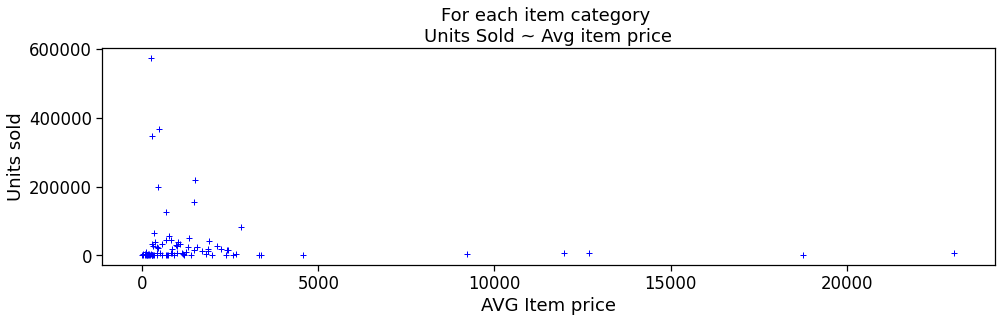

In [8]:
# Scater p;ot
df = train_agg[['item_category_id', 'units_sold', 'revenue']].groupby(
    ['item_category_id'])['units_sold', 'revenue'].sum()

df = df.reset_index()
df['avg_item_price'] = round(df.revenue / df.units_sold, 2)

f, ax = plt.subplots(figsize=(16, 4))
plt.scatter(y="units_sold", x="avg_item_price", data=df, c="b", s=30, linewidth=1, marker="+")
plt.xlabel("AVG Item price")
plt.ylabel("Units sold")
plt.title("For each item category \nUnits Sold ~ Avg item price");

# Plotting Overall Monthly trend

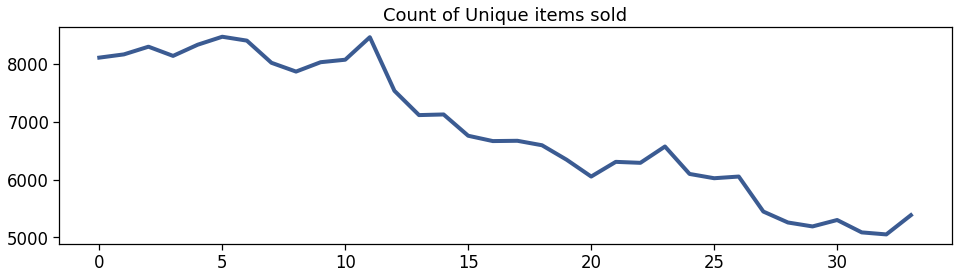

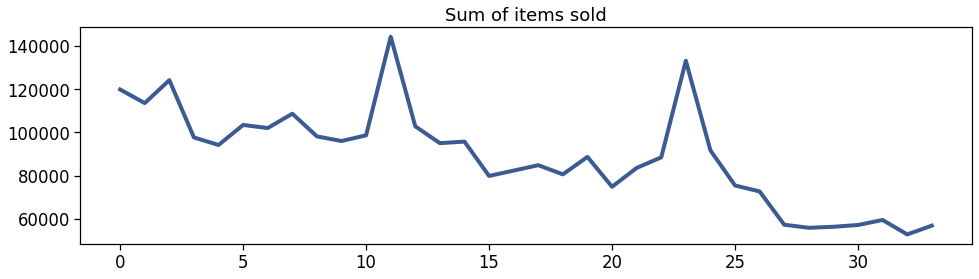

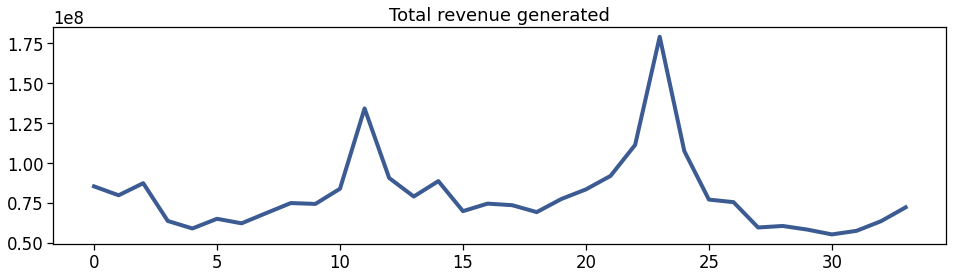

In [9]:
df = train_agg[['date_block_num', 'item_id']].groupby(by='date_block_num', as_index=False).nunique()

fig, ax = plt.subplots(figsize=(16,4))
plt.plot(df.item_id, sns.xkcd_rgb["denim blue"], lw=4)
plt.title("Count of Unique items sold")


df = train_agg[['date_block_num', 'units_sold']].groupby(by='date_block_num', as_index=False).sum()

f, ax = plt.subplots(figsize=(16, 4))
plt.plot(df.units_sold, sns.xkcd_rgb["denim blue"], lw=4)
plt.title("Sum of items sold")


df = train_agg[['date_block_num', 'revenue']].groupby(by='date_block_num', as_index=False).sum()

f, ax = plt.subplots(figsize=(16, 4))
plt.plot(df.revenue, sns.xkcd_rgb["denim blue"], lw=4)
plt.title("Total revenue generated");

# Shop analysis

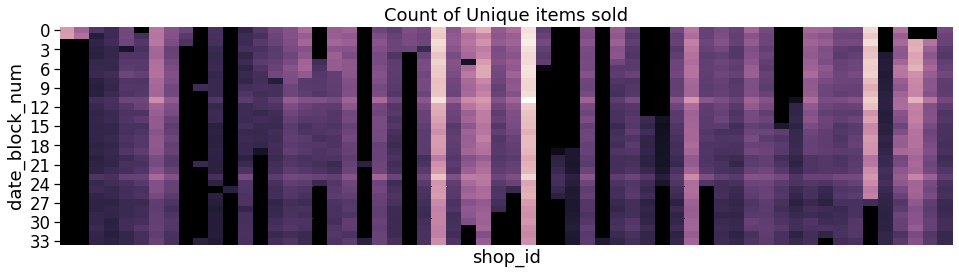

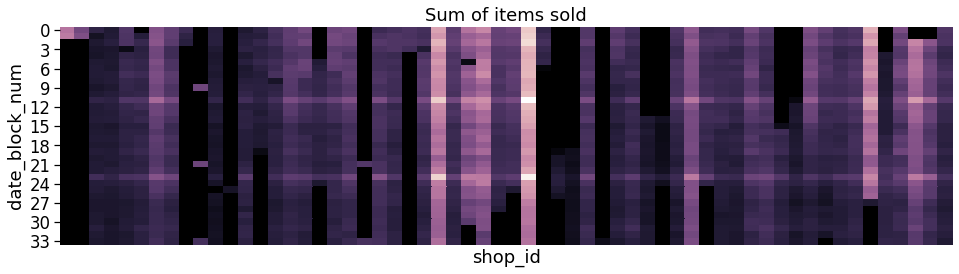

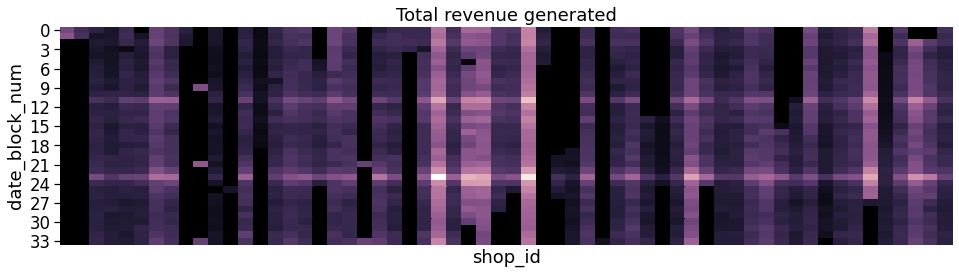

In [11]:
stores_hm = train_agg.pivot_table(index='date_block_num', columns='shop_id', values='item_id', aggfunc='nunique', fill_value=0)

fig, ax = plt.subplots(figsize=(16,4))
cmap = sns.cubehelix_palette(8, as_cmap=True, dark=0, light=1, gamma=0.8, reverse=True)
plt.title("Count of Unique items sold")
_ = sns.heatmap(stores_hm, ax=ax, cmap=cmap, cbar=False, xticklabels=False)


stores_hm = train_agg.pivot_table(index='date_block_num', columns='shop_id', values='units_sold', aggfunc='sum', fill_value=0)

fig, ax = plt.subplots(figsize=(16,4))
cmap = sns.cubehelix_palette(8, as_cmap=True, dark=0, light=1, gamma = .8, reverse=True)
plt.title("Sum of items sold")
_ = sns.heatmap(stores_hm, ax=ax, cmap=cmap, cbar=False, xticklabels=False)


stores_hm = train_agg.pivot_table(index='date_block_num', columns='shop_id', values='revenue', aggfunc='sum', fill_value=0)

fig, ax = plt.subplots(figsize=(16,4))
cmap = sns.cubehelix_palette(8, as_cmap=True, dark=0, light=1, gamma = .8, reverse=True)
plt.title("Total revenue generated")
_ = sns.heatmap(stores_hm, ax=ax, cmap=cmap, cbar=False, xticklabels=False)

# Category analysis

C:\Users\andrii.shchur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


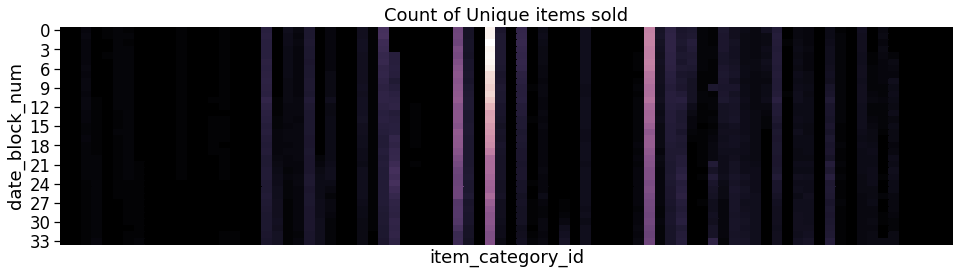

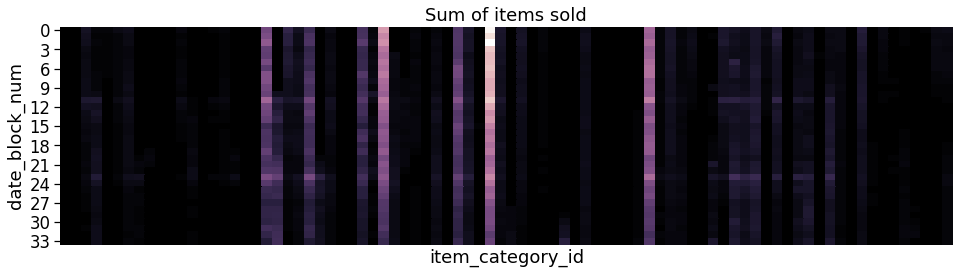

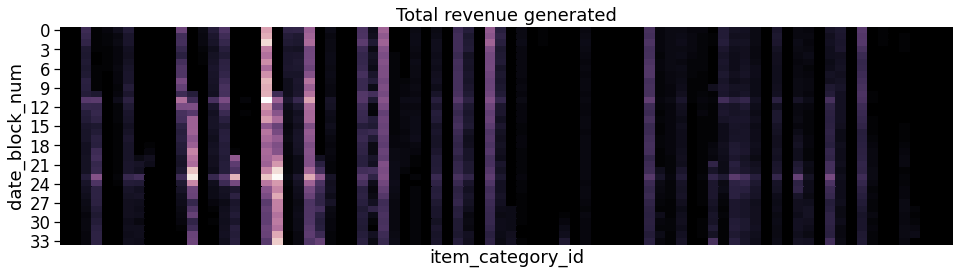

In [12]:
stores_hm = train_agg.pivot_table(index='date_block_num', columns='item_category_id', values='item_id', aggfunc='nunique', fill_value=0)

fig, ax = plt.subplots(figsize=(16,4))
cmap = sns.cubehelix_palette(8, as_cmap=True, dark=0, light=1, gamma=0.8, reverse=True)
plt.title("Count of Unique items sold")
_ = sns.heatmap(stores_hm, ax=ax, cmap=cmap, cbar=False, xticklabels=False)


stores_hm = train_agg.pivot_table(index='date_block_num', columns='item_category_id', values='units_sold', aggfunc='sum', fill_value=0)

fig, ax = plt.subplots(figsize=(16,4))
cmap = sns.cubehelix_palette(8, as_cmap=True, dark=0, light=1, gamma = .8, reverse=True)
plt.title("Sum of items sold")
_ = sns.heatmap(stores_hm, ax=ax, cmap=cmap, cbar=False, xticklabels=False)


stores_hm = train_agg.pivot_table(index='date_block_num', columns='item_category_id', values='revenue', aggfunc='sum', fill_value=0)

fig, ax = plt.subplots(figsize=(16,4))
cmap = sns.cubehelix_palette(8, as_cmap=True, dark=0, light=1, gamma = .8, reverse=True)
plt.title("Total revenue generated")
_ = sns.heatmap(stores_hm, ax=ax, cmap=cmap, cbar=False, xticklabels=False)

# What category/shop sells more?

In [19]:
train = train.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_cats, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
# Only shops that exist in test set.
train = train[train['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
train = train[train['item_id'].isin(test_item_ids)]
train = train.query('item_price > 0')

train_monthly = train[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]

# Group by month in this case "date_block_num" and aggregate features.
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
# Rename features.
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

# Build a data set with all the possible combinations of ['date_block_num','shop_id','item_id'] so we won't have missing records.
shop_ids = train_monthly['shop_id'].unique()
item_ids = train_monthly['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])

# Merge the train set with the complete set (missing records will be filled with 0).
train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')
train_monthly.fillna(0, inplace=True)

# Extract time based features.
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12))

gp_category_mean = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
gp_category_sum = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
gp_shop_mean = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

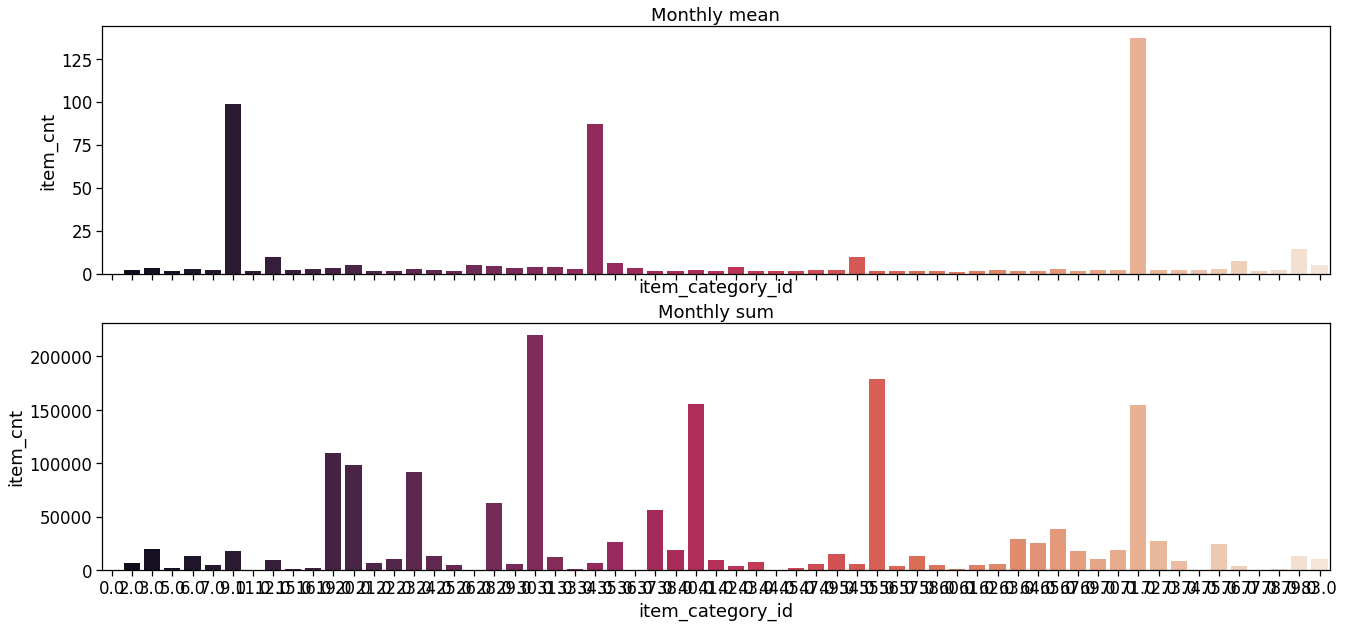

In [21]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

C:\Users\andrii.shchur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


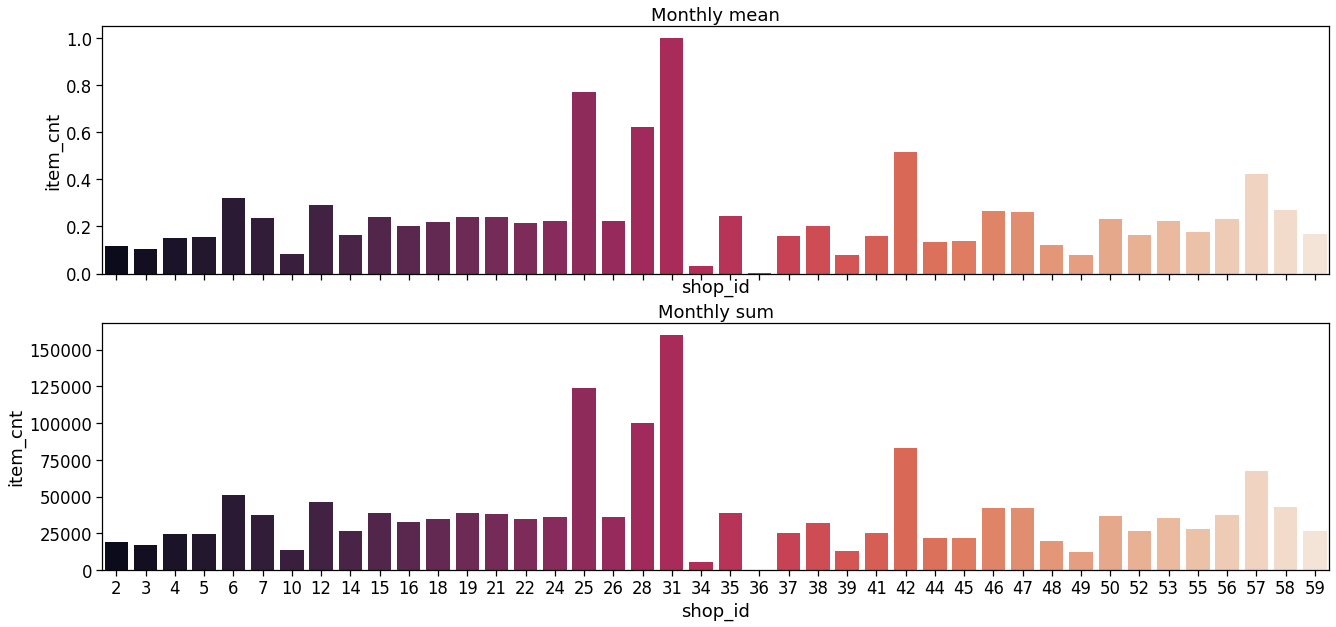

In [22]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()